In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

torch.manual_seed(2023)
np.random.seed(2023)
torch.set_float32_matmul_precision('medium')


/tmp/ipykernel_435464/832361833.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
from typing import Any, Callable, List, Tuple, Dict
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import lightning.pytorch as L

class AutoEncoder(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Linear(784, 512)
        self.latent_space = nn.Linear(512, 256)
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.Linear(512, 784),
            nn.LeakyReLU()
        )
    
        
        self.criterion = nn.MSELoss()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.encoder(x)
        out = F.leaky_relu(out)
        out = self.latent_space(out)
        out = F.leaky_relu(out)
        out = self.decoder(out)
        out = F.leaky_relu(out)
        
        return out
    
    def configure_optimizers(self) -> Any:
        return optim.AdamW(params=self.parameters(), lr=0.0005)    
    
    def __compute_loss(self, batch: torch.Tensor) -> torch.Tensor:
        out = self(batch)
        loss = self.criterion(out, batch)
        return loss
    
    
    def training_step(self, batch: torch.Tensor, batch_idx: int) -> STEP_OUTPUT:
        loss = self.__compute_loss(batch)
        self.log("training_loss", loss, prog_bar=True)
        
        return {
            "loss": loss,
            "log": {
                "training_loss": loss
            }
        }
    
    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> STEP_OUTPUT:
        loss = self.__compute_loss(batch)
        self.log("validation_loss", loss, prog_bar=True)
        
        return {
            "loss": loss,
            "log": {
                "validation_loss": loss
            }
        }


In [3]:
from torchvision.datasets import MNIST

train_dataset = MNIST(root="~/.cache/torchvision_cache", download=True, train=True)
val_dataset = MNIST(root="~/.cache/torchvision_cache", train=False)


In [4]:
from torch.utils.data import DataLoader
from einops import rearrange


def collate(batch: Any) -> torch.Tensor:
    images =  list(zip(*batch))[0]
    image_arrays = np.array([np.array(im).flatten() for im in images], dtype=np.float32)
    
    return torch.from_numpy(image_arrays / 255.0)
    
    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256, collate_fn=collate)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=256, collate_fn=collate)

# for batch in train_loader:
#     print(batch)
#     break


In [5]:
def train(epochs=20):
    trainer = L.Trainer(accelerator="gpu", devices=1, max_epochs=epochs, benchmark=True)
    model = AutoEncoder()
    trainer.fit(model, train_loader, val_loader)
    
    return model


In [6]:
model = train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Linear     | 401 K 
1 | latent_space | Linear     | 131 K 
2 | decoder      | Sequential | 533 K 
3 | criterion    | MSELoss    | 0     
--------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.268     Total estimated model params size (MB)


Sanity Checking: |                                                                                    | 0/? [0…

/home/shawon/miniconda3/envs/exp/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/shawon/miniconda3/envs/exp/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                           | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

`Trainer.fit` stopped: `max_epochs=20` reached.


0


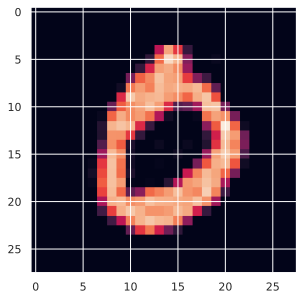

In [7]:
@torch.no_grad()
def inference(image, model=model):
    inputs = torch.from_numpy(np.array(image, dtype=np.float32) / 255.0)
    gen = model(torch.flatten(inputs))
    
    gen = torch.unflatten(gen, dim=-1, sizes=(28, 28))
    gen = gen.cpu().numpy()
    
    return gen


sample = val_dataset[3]
gen = inference(sample[0])
plt.imshow(gen)
print(sample[1])


In [8]:
def randomly_pick_n(n: int=8, max=len(val_dataset)) -> Tuple:
    indexes = torch.randint(0, max, size=(n, )).tolist()
    selection = [val_dataset[i][0] for i in indexes]
    actuals = [np.array(im, dtype=np.float32) for im in selection]
    generated = [inference(im) for im in selection]
    
    return generated, actuals
    

In [9]:
generated, actuals = randomly_pick_n()


In [10]:
def comparison_plot(generated: list, actuals: list) -> None:
    fig = plt.figure(1, figsize=[12, 6])
    fig.tight_layout()
    
    for idx, gen in enumerate(generated):
        ax = fig.add_subplot(1, len(generated), idx + 1)
        ax.set_title(f"generated_{idx}")
        plt.imshow(gen)
        plt.axis("off")
        
    for idx, act in enumerate(actuals):
        ax = fig.add_subplot(2, len(actuals), idx + 1)
        ax.set_title(f"actual_{idx}")
        plt.imshow(act)
        plt.axis("off")
    
    fig.suptitle("Actual (upper) vs Generated(lower)")
    


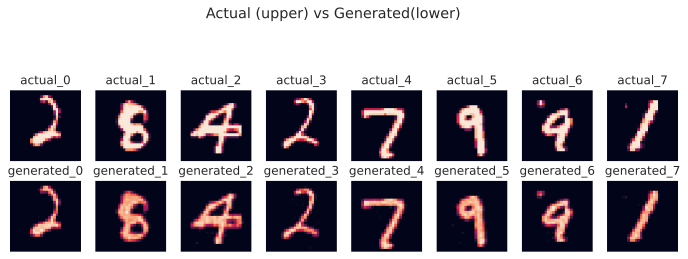

In [11]:
comparison_plot(generated, actuals)
